In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from scipy.integrate import solve_ivp
from scipy.special import erfinv
import pandas as pd
import time

def randn2(*args,**kwargs):
    '''
    Calls rand and applies inverse transform sampling to the output.
    '''
    uniform = np.random.rand(*args, **kwargs)
    return np.sqrt(2) * erfinv(2 * uniform - 1)

# import pickle file 
with open('../scenario-properties-test.pkl', 'rb') as f:
    baseline = pickle.load(f)

# Parameters
N_shell = baseline.n_shells
R02 = baseline.R0_km

tf_ss = 100
Ts = 100
tspan = np.linspace(0, tf_ss, Ts)

# ODE tolerances
rtol = 1e-2
atol = 1e-2

# Selection
np.random.seed(25) # Seed for reproducibility
sel_ic = 1 # 1: IC from predefined array; 2: IC from MC2SSEM_population 
sel_controller = 1; # 1: PD, 2: NMPC

#==========================================================================
# Control Settings
#==========================================================================
# PD gains - Launch rate (lambda)
K_p = 1 * 1
K_d = 1 * 1

# PD gains - Active Debris Removal (ADR)
K_p_adrD = 1 * 1
K_d_adrD = 1 * 1
K_p_adrN = 1 * 1
K_d_adrN = 1 * 1

# MPC - Prediction horizon steps
Tp = 5

# MPC - Control horizon steps
Tc = 3 # Positive integer, m, between 1 and p, inclusive, 
# where p is equal to PredictionHorizon. In this case, the controller computes 
# m free control moves occurring at times k through k+m-1, and holds the controller 
# output constant for the remaining prediction horizon steps from k+m through k+p-1. 
# Here, k is the current control interval.
# The product of Tp and Ts is the prediction time; that is,
# how far the controller looks into the future.

# ADR Saturation Functions (Lambda Functions)
sat_D = lambda t: -(2 + np.floor(t / 10) * 5)
sat_N = lambda t: -(2 + np.floor(t / 10) * 5)

#==========================================================================
# Initial conditions
#==========================================================================
if sel_ic == 1:
    # Mean and standard deviation values
    S_mean = 142
    S_std = 497
    D_mean = 73
    D_std = 79
    N_mean = 280
    N_std = 354

    # Generate random values and create initial conditions
    S_rand = randn2(N_shell)
    x0_S = np.abs(np.round(S_mean + S_std * S_rand)).astype(int)
    D_rand = randn2(N_shell)
    x0_D = np.abs(np.round(D_mean + D_std * D_rand)).astype(int)
    N_rand = randn2(N_shell)
    x0_N = np.abs(np.round(N_mean + N_std * N_rand)).astype(int)

    # Combine initial conditions
    x0 = np.concatenate((x0_S, x0_N, x0_D))
    spec_names = ["Su", "N", "D"]
    VAR = {"N_shell": N_shell}  

    # Create pandas DataFrame (equivalent to MATLAB's table)
    df = pd.DataFrame(x0.reshape((3,N_shell)).T, columns=spec_names)
    # print(df.to_string(index=False)) # Print DataFrame without index

    # Print table with shell numbers (optional)
    df_with_shell = pd.DataFrame(np.column_stack((np.arange(1, N_shell+1),x0.reshape((3,N_shell)).T)), 
                                   columns=['Shell'] + spec_names)
    print(df_with_shell.to_string(index=False)) # Print DataFrame without index

#==========================================================================
# Reference values
#==========================================================================
ref_S = x0_S * 2 * 1
ref_D = x0_D * 0.5 * 1
ref_N = x0_N * 0.5 * 1
ref_S_dot = np.ones(N_shell) * -1 * 0
ref_D_dot = np.ones(N_shell) * -1 * 0
ref_N_dot = np.ones(N_shell) * -1 * 0

#==========================================================================
# Launch rate (lambda) selection
#==========================================================================
# Lambda functions for launch rate selection
def x0_lam_f1(t):
    return np.zeros(N_shell)

def x0_lam_f2(t):
    return 0.5 * x0_S

def x0_lam_f3(t):
    return np.random.rand(N_shell) * x0_S

# Define parameters for x0_lam_f4
lam_mean = 150
lam_std = 30

def x0_lam_f4(t):
    return np.round(lam_mean + lam_std * randn2(N_shell)).astype(int)

# Define phase shifts for x0_lam_f5
phase_shifts = 2 * np.pi / np.random.randint(1, N_shell + 1, size=N_shell)

def x0_lam_f5(t):
    return 0.5 * x0_S * (np.cos((2*np.pi/10)*t + phase_shifts) / 3 + 1)

# Initialize arrays 
x0_lam_no_noise = np.zeros((N_shell, len(tspan)))
x0_lam = np.zeros((N_shell, len(tspan)))

# Evaluate lambda functions for each time step
for i1 in range(len(tspan)):
    x0_lam_no_noise[:, i1] = x0_lam_f1(tspan[i1])
    x0_lam[:, i1] = x0_lam_f1(tspan[i1]) 

 Shell  Su   N   D
     1 702 209   5
     2 245 224  77
     3 149  75  37
     4 302 734 114
     5  30 435  46
     6 449 241 150
     7 381  84  69
     8  64 303  76
     9 212 333  49
    10  27 514 295
    11  19 615  76
    12 460 609  85
    13  76 224  71
    14 249 412 119


/Users/glavezzi/Desktop/pyssem/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# MOCAT-3 w/o debris spreading function (from matlab)
# 200-900 km, 14 shells
# P = 0.9; 
# alpha = 0.2; 
# alpha_active = 0.1;
# delta = 0;
# Dt = 8;
# mass      = [192.9379  192.9379   16.9068];      
# Area         = [4.9564    4.9564    0.4952];
# diameter  = [2.5121    2.5121    0.7941];

lambda_1, lambda_2, lambda_3, lambda_4, lambda_5, lambda_6, lambda_7, lambda_8, lambda_9, lambda_10, lambda_11, lambda_12, lambda_13, lambda_14 = sp.symbols('lambda_1 lambda_2 lambda_3 lambda_4 lambda_5 lambda_6 lambda_7 lambda_8 lambda_9 lambda_10 lambda_11 lambda_12 lambda_13 lambda_14')
S_1, S_2, S_3, S_4, S_5, S_6, S_7, S_8, S_9, S_10, S_11, S_12, S_13, S_14 = sp.symbols('S_1 S_2 S_3 S_4 S_5 S_6 S_7 S_8 S_9 S_10 S_11 S_12 S_13 S_14')
N_1, N_2, N_3, N_4, N_5, N_6, N_7, N_8, N_9, N_10, N_11, N_12, N_13, N_14 = sp.symbols('N_1 N_2 N_3 N_4 N_5 N_6 N_7 N_8 N_9 N_10 N_11 N_12 N_13 N_14')
D_1, D_2, D_3, D_4, D_5, D_6, D_7, D_8, D_9, D_10, D_11, D_12, D_13, D_14 = sp.symbols('D_1 D_2 D_3 D_4 D_5 D_6 D_7 D_8 D_9 D_10 D_11 D_12 D_13 D_14')

full_lambda = sp.Matrix(sp.symbols([f'lambda_{i+1}' for i in range(baseline.n_shells)]))
full_lambda_flattened = [full_lambda[i, j] for j in range(full_lambda.cols) for i in range(full_lambda.rows)]

mocat3 = [lambda_1 - S_1/8 - (3736148020190767*N_1*S_1)/188894659314785808547840 - (3451116821312583*S_1**2)/151115727451828646838272 - (8627792053281457*D_1*S_1)/188894659314785808547840,
lambda_2 - S_2/8 - (1472081120406105*N_2*S_2)/75557863725914323419136 - (424929958736517*S_2**2)/18889465931478580854784 - (8498599174730339*D_2*S_2)/188894659314785808547840,
lambda_3 - S_3/8 - (362550482468311*N_3*S_3)/18889465931478580854784 - (52326790765669*S_3**2)/2361183241434822606848 - (52326790765669*D_3*S_3)/1180591620717411303424,
lambda_4 - S_4/8 - (3572017290185999*N_4*S_4)/188894659314785808547840 - (412438455648729*S_4**2)/18889465931478580854784 - (412438455648729*D_4*S_4)/9444732965739290427392,
lambda_5 - S_5/8 - (879926185969197*N_5*S_5)/47223664828696452136960 - (3251186029569209*S_5**2)/151115727451828646838272 - (4063982536961511*D_5*S_5)/94447329657392904273920,
lambda_6 - S_6/8 - (3468533020704617*N_6*S_6)/188894659314785808547840 - (6407836407092163*S_6**2)/302231454903657293676544 - (8009795508865203*D_6*S_6)/188894659314785808547840,
lambda_7 - S_7/8 - (213654324276147*N_7*S_7)/11805916207174113034240 - (1578836873637433*S_7**2)/75557863725914323419136 - (1973546092046791*D_7*S_7)/47223664828696452136960,
lambda_8 - S_8/8 - (1347792597827603*N_8*S_8)/75557863725914323419136 - (6224846661409747*S_8**2)/302231454903657293676544 - (7781058326762183*D_8*S_8)/188894659314785808547840,
lambda_9 - S_9/8 - (3321539316150579*N_9*S_9)/188894659314785808547840 - (6136277334126103*S_9**2)/302231454903657293676544 - (1917586666914407*D_9*S_9)/47223664828696452136960,
lambda_10 - S_10/8 - (3274613111731563*N_10*S_10)/188894659314785808547840 - (3024792468637393*S_10**2)/151115727451828646838272 - (3780990585796741*D_10*S_10)/94447329657392904273920,
lambda_11 - S_11/8 - (6457348751873167*N_11*S_11)/377789318629571617095680 - (5964716809462337*S_11**2)/302231454903657293676544 - (7455896011827921*D_11*S_11)/188894659314785808547840,
lambda_12 - S_12/8 - (3183695596147321*N_12*S_12)/188894659314785808547840 - (5881622123334291*S_12**2)/302231454903657293676544 - (7352027654167863*D_12*S_12)/188894659314785808547840,
lambda_13 - S_13/8 - (6279300422599697*N_13*S_13)/377789318629571617095680 - (1450062952364139*S_13**2)/75557863725914323419136 - (1450062952364139*D_13*S_13)/37778931862957161709568,
lambda_14 - S_14/8 - (3096512572663703*N_14*S_14)/188894659314785808547840 - (5720558483857907*S_14**2)/302231454903657293676544 - (7150698104822383*D_14*S_14)/188894659314785808547840,
(7524287222334625*D_1**2)/73786976294838206464 + (8253489591037723*D_1*N_1)/295147905179352825856 + (1504857444466925*D_1*S_1)/73786976294838206464 + (3875027506905303*N_1**2)/2361183241434822606848 + (8253489591037723*N_1*S_1)/1475739525896764129280 - (7795668895967009*N_1)/13421772800000 + (1504857444466925*S_1**2)/147573952589676412928 + (406721697626559*N_2)/2684354560000,
(3705809133047323*D_2**2)/36893488147419103232 + (2032475382863473*D_2*N_2)/73786976294838206464 + (3705809133047323*D_2*S_2)/184467440737095516160 + (7634005402278429*N_2**2)/4722366482869645213696 + (2032475382863473*N_2*S_2)/368934881474191032320 - (406721697626559*N_2)/2684354560000 + (5929294612875717*S_2**2)/590295810358705651712 + (136196951356517*N_3)/2684354560000,
(7301461151820955*D_3**2)/73786976294838206464 + (8009068744351095*D_3*N_3)/295147905179352825856 + (1460292230364191*D_3*S_3)/73786976294838206464 + (3760271500524651*N_3**2)/2361183241434822606848 + (1601813748870219*N_3*S_3)/295147905179352825856 - (136196951356517*N_3)/2684354560000 + (1460292230364191*S_3**2)/147573952589676412928 + (4304934392914871*N_4)/214748364800000,
(7193741765384481*D_4**2)/73786976294838206464 + (3945454966483313*D_4*N_4)/147573952589676412928 + (7193741765384481*D_4*S_4)/368934881474191032320 + (3704795736092205*N_4**2)/2361183241434822606848 + (3945454966483313*N_4*S_4)/737869762948382064640 - (4304934392914871*N_4)/214748364800000 + (5754993412307585*S_4**2)/590295810358705651712 + (1352835115998399*N_5)/171798691840000,
(7088388706127989*D_5**2)/73786976294838206464 + (7775346776980717*D_5*N_5)/295147905179352825856 + (7088388706127989*D_5*S_5)/368934881474191032320 + (3650538636317529*N_5**2)/2361183241434822606848 + (7775346776980717*N_5*S_5)/1475739525896764129280 - (1352835115998399*N_5)/171798691840000 + (708838870612799*S_5**2)/73786976294838206464 + (1444387816658031*N_6)/429496729600000,
(1746333292129637*D_6**2)/18446744073709551616 + (7662303802699571*D_6*N_6)/295147905179352825856 + (1746333292129637*D_6*S_6)/92233720368547758080 + (7194929532344093*N_6**2)/4722366482869645213696 + (7662303802699571*N_6*S_6)/1475739525896764129280 - (1444387816658031*N_6)/429496729600000 + (2794133267407419*S_6**2)/295147905179352825856 + (5097704463546253*N_7)/3435973836800000,
(1721127207444493*D_7**2)/18446744073709551616 + (943963532474465*D_7*N_7)/36893488147419103232 + (1721127207444493*D_7*S_7)/92233720368547758080 + (886384992313085*N_7**2)/590295810358705651712 + (188792706494893*N_7*S_7)/36893488147419103232 - (5097704463546253*N_7)/3435973836800000 + (2753803531911189*S_7**2)/295147905179352825856 + (4674537275202647*N_8)/6871947673600000,
(3392925871575083*D_8**2)/36893488147419103232 + (7443490004231567*D_8*N_8)/295147905179352825856 + (3392925871575083*D_8*S_8)/184467440737095516160 + (436841414101569*N_8**2)/295147905179352825856 + (7443490004231567*N_8*S_8)/1475739525896764129280 - (4674537275202647*N_8)/6871947673600000 + (5428681394520133*S_8**2)/590295810358705651712 + (1071587407478539*N_9)/3435973836800000,
(3344650118241005*D_9**2)/36893488147419103232 + (3668790693505713*D_9*N_9)/147573952589676412928 + (668930023648201*D_9*S_9)/36893488147419103232 + (3445007035533279*N_9**2)/2361183241434822606848 + (3668790693505713*N_9*S_9)/737869762948382064640 - (1071587407478539*N_9)/3435973836800000 + (668930023648201*S_9**2)/73786976294838206464 + (8578509302837371*N_10)/54975581388800000,
(6594794815820267*D_10**2)/73786976294838206464 + (7233917148435707*D_10*N_10)/295147905179352825856 + (6594794815820267*D_10*S_10)/368934881474191032320 + (6792672995747457*N_10**2)/4722366482869645213696 + (7233917148435707*N_10*S_10)/1475739525896764129280 - (8578509302837371*N_10)/54975581388800000 + (2637917926328107*S_10**2)/295147905179352825856 + (536501686416211*N_11)/6871947673600000,
(6502278073741423*D_11**2)/73786976294838206464 + (3566217158773353*D_11*N_11)/147573952589676412928 + (6502278073741423*D_11*S_11)/368934881474191032320 + (6697380269722693*N_11**2)/4722366482869645213696 + (3566217158773353*N_11*S_11)/737869762948382064640 - (536501686416211*N_11)/6871947673600000 + (5201822458993139*S_11**2)/590295810358705651712 + (4901371670897217*N_12)/109951162777600000,
(6411694602151005*D_12**2)/73786976294838206464 + (7033072116477033*D_12*N_12)/295147905179352825856 + (1282338920430201*D_12*S_12)/73786976294838206464 + (6604078822366479*N_12**2)/4722366482869645213696 + (7033072116477033*N_12*S_12)/1475739525896764129280 - (4901371670897217*N_12)/109951162777600000 + (1282338920430201*S_12**2)/147573952589676412928 + (349820459363559*N_13)/13743895347200000,
(6322990909304883*D_13**2)/73786976294838206464 + (6935771869429191*D_13*N_13)/295147905179352825856 + (6322990909304883*D_13*S_13)/368934881474191032320 + (3256356778451929*N_13**2)/2361183241434822606848 + (6935771869429191*N_13*S_13)/1475739525896764129280 - (349820459363559*N_13)/13743895347200000 + (2529196363721953*S_13**2)/295147905179352825856 + (3760563854089713*N_14)/219902325555200000,
(6236115340821633*D_14**2)/73786976294838206464 + (3420238458016497*D_14*N_14)/147573952589676412928 + (6236115340821633*D_14*S_14)/368934881474191032320 + (6423231269053031*N_14**2)/4722366482869645213696 + (3420238458016497*N_14*S_14)/737869762948382064640 - (3760563854089713*N_14)/219902325555200000 + (4988892272657307*S_14**2)/590295810358705651712,
(7134391170356971*D_2)/53687091200000 - (3418636850638337*D_1)/6710886400000 + S_1/80 - (8627792053281457*D_1**2)/37778931862957161709568 - (3736148020190767*D_1*N_1)/37778931862957161709568,
(2389059479387907*D_3)/53687091200000 - (7134391170356971*D_2)/53687091200000 + S_2/80 - (8498599174730339*D_2**2)/37778931862957161709568 - (7360405602030525*D_2*N_2)/75557863725914323419136,
(235980509684243*D_4)/13421772800000 - (2389059479387907*D_3)/53687091200000 + S_3/80 - (261633953828345*D_3**2)/1180591620717411303424 - (1812752412341555*D_3*N_3)/18889465931478580854784,
(5932591599397359*D_5)/858993459200000 - (235980509684243*D_4)/13421772800000 + S_4/80 - (2062192278243645*D_4**2)/9444732965739290427392 - (3572017290185999*D_4*N_4)/37778931862957161709568,
(1266815582481889*D_6)/429496729600000 - (5932591599397359*D_5)/858993459200000 + S_5/80 - (4063982536961511*D_5**2)/18889465931478580854784 - (879926185969197*D_5*N_5)/9444732965739290427392,
(4470995514383249*D_7)/3435973836800000 - (1266815582481889*D_6)/429496729600000 + S_6/80 - (8009795508865203*D_6**2)/37778931862957161709568 - (3468533020704617*D_6*N_6)/37778931862957161709568,
(4099852264622891*D_8)/6871947673600000 - (4470995514383249*D_7)/3435973836800000 + S_7/80 - (1973546092046791*D_7**2)/9444732965739290427392 - (213654324276147*D_7*N_7)/2361183241434822606848,
(7518776384730923*D_9)/27487790694400000 - (4099852264622891*D_8)/6871947673600000 + S_8/80 - (7781058326762183*D_8**2)/37778931862957161709568 - (6738962989138015*D_8*N_8)/75557863725914323419136,
(1880968036071637*D_10)/13743895347200000 - (7518776384730923*D_9)/27487790694400000 + S_9/80 - (1917586666914407*D_9**2)/9444732965739290427392 - (3321539316150579*D_9*N_9)/37778931862957161709568,
(7528711483622597*D_11)/109951162777600000 - (1880968036071637*D_10)/13743895347200000 + S_10/80 - (3780990585796741*D_10**2)/18889465931478580854784 - (3274613111731563*D_10*N_10)/37778931862957161709568,
(1719519906390333*D_12)/43980465111040000 - (7528711483622597*D_11)/109951162777600000 + S_11/80 - (7455896011827921*D_11**2)/37778931862957161709568 - (6457348751873167*D_11*N_11)/75557863725914323419136,
(2454509814507247*D_13)/109951162777600000 - (1719519906390333*D_12)/43980465111040000 + S_12/80 - (7352027654167863*D_12**2)/37778931862957161709568 - (3183695596147321*D_12*N_12)/37778931862957161709568,
(3298242227147567*D_14)/219902325555200000 - (2454509814507247*D_13)/109951162777600000 + S_13/80 - (7250314761820695*D_13**2)/37778931862957161709568 - (6279300422599697*D_13*N_13)/75557863725914323419136,
S_14/80 - (3298242227147567*D_14)/219902325555200000 - (7150698104822383*D_14**2)/37778931862957161709568 - (3096512572663703*D_14*N_14)/37778931862957161709568]

equations_flattened = mocat3


In [3]:
# # Model from .json file

# # Equations
# baseline.equations
# # x0 initial population
# baseline.x0
# # baseline
# baseline.all_symbolic_vars
# # solver
# equations_flattened = [baseline.equations[i, j] for j in range(baseline.equations.cols) for i in range(baseline.equations.rows)]

# # Add lambda variables
# full_lambda = sp.Matrix(sp.symbols([f'lambda_{i+1}' for i in range(baseline.n_shells)]))
# full_lambda_flattened = [full_lambda[i, j] for j in range(full_lambda.cols) for i in range(full_lambda.rows)]
# for i1 in range(baseline.n_shells):
#     equations_flattened[i1] = equations_flattened[i1]+full_lambda_flattened[i1]

In [4]:
# Add controller variables
full_u_lam = sp.Matrix(sp.symbols([f'u_lam_{i+1}' for i in range(baseline.n_shells)]))
full_u_adr_d = sp.Matrix(sp.symbols([f'u_adr_d_{i+1}' for i in range(baseline.n_shells)]))
full_u_adr_n = sp.Matrix(sp.symbols([f'u_adr_n_{i+1}' for i in range(baseline.n_shells)])) 

u_lam_flattened = [full_u_lam[i, j] for j in range(full_u_lam.cols) for i in range(full_u_lam.rows)]
u_adr_d_flattened = [full_u_adr_d[i, j] for j in range(full_u_adr_d.cols) for i in range(full_u_adr_d.rows)]
u_adr_n_flattened = [full_u_adr_n[i, j] for j in range(full_u_adr_n.cols) for i in range(full_u_adr_n.rows)]

equations_flattened_nc = equations_flattened.copy()

for i1 in range(0,baseline.n_shells):
    equations_flattened[i1] = equations_flattened[i1] + u_lam_flattened[i1]
for i1 in range(baseline.n_shells,2*baseline.n_shells):
    equations_flattened[i1] = equations_flattened[i1] + u_adr_n_flattened[i1-baseline.n_shells]
for i1 in range(2*baseline.n_shells,3*baseline.n_shells):
    equations_flattened[i1] = equations_flattened[i1] + u_adr_d_flattened[i1-2*baseline.n_shells]

# Define variables
var = baseline.all_symbolic_vars 
lam = full_lambda_flattened
u_var = u_lam_flattened + u_adr_n_flattened + u_adr_d_flattened

func_nc = sp.lambdify((var,lam), equations_flattened_nc, 'numpy')
func = sp.lambdify((var,lam,u_var), equations_flattened, 'numpy')

In [5]:
def ode_func_nc(t, x, func_nc, lam):
    return np.array(func_nc(x, lam)).flatten()

def ode_func(t, x, func, u_var, lam):
    return np.array(func(x, u_var, lam)).flatten()


#==========================================================================
# Propagation without control
#==========================================================================

x00 = x0[:3*N_shell]
x_prop_nc = np.zeros((len(tspan), 3*N_shell))
x_prop_nc[0, :] = x00

for i1 in range(len(tspan) - 1):
    # md = np.concatenate((x0_lam[:, i1], PMD[i1])) 
    md = x0_lam[:, i1] 
    sol = solve_ivp(ode_func_nc, 
                    (tspan[i1], tspan[i1+1]), 
                    x00, 
                    method=baseline.integrator,
                    args=(func_nc,md),
                    rtol=rtol, atol=atol)
    x_prop_nc[i1+1, :] = sol.y[:, -1]
    x00 = sol.y[:, -1]

t_prop_nc = tspan
S_prop_nc = x_prop_nc[:, 0:N_shell]
N_prop_nc = x_prop_nc[:, N_shell:2*N_shell]
D_prop_nc = x_prop_nc[:, 2*N_shell:3*N_shell]
N_tot_nc = S_prop_nc + D_prop_nc + N_prop_nc
N_tot_sum_nc = np.sum(N_tot_nc, axis=1)
S_sum_nc = np.sum(S_prop_nc, axis=1)
D_sum_nc = np.sum(D_prop_nc, axis=1)
N_sum_nc = np.sum(N_prop_nc, axis=1)

#==========================================================================
# Propagation with control
#==========================================================================

x00 = x0[0:3*N_shell]

if sel_controller == 1:
#==========================================================================
# PD
#==========================================================================
    # Initialize arrays
    x_prop_all = np.zeros((len(tspan), 3*N_shell))
    lam_prop = np.zeros((len(tspan), N_shell))
    adr_d_prop = np.zeros((len(tspan), N_shell))
    adr_n_prop = np.zeros((len(tspan), N_shell))

    x_prop_all[0, :] = x00
    lam_prop[0, :] = np.zeros(N_shell)
    adr_d_prop[0, :] = np.zeros(N_shell)
    adr_n_prop[0, :] = np.zeros(N_shell)

    # Start timing
    start_time = time.time()

    for i1 in range(len(tspan) - 1):
        # md_no_noise = np.concatenate((x0_lam_no_noise[:, i1], [PMD_no_noise[i1], Alpha_no_noise[i1], alpha_active_no_noise[i1], Delta_no_noise[i1]]))
        # md = np.concatenate((x0_lam[:, i1], [PMD[i1], Alpha[i1], alpha_active[i1], Delta[i1]]))
        md_no_noise = x0_lam_no_noise[:, i1]
        md = x0_lam[:, i1]

        sol = solve_ivp(ode_func_nc, 
                        (tspan[i1], tspan[i1+1]), 
                        x00, 
                        method=baseline.integrator,
                        args=(func_nc,md_no_noise),
                        rtol=rtol, atol=atol)
        x_prop = sol.y[:, -1]
        
        sol_actual = solve_ivp(ode_func_nc, 
                        (tspan[i1], tspan[i1+1]), 
                        x00, 
                        method=baseline.integrator,
                        args=(func_nc,md),
                        rtol=rtol, atol=atol)
        x_prop_actual = sol_actual.y[:, -1]

        S_prop = x_prop[0:N_shell]
        N_prop = x_prop[N_shell:2*N_shell]
        D_prop = x_prop[2*N_shell:3*N_shell]

        x_dot_prop = np.array(func_nc(x_prop, md_no_noise)).flatten()
        S_dot = x_dot_prop[0:N_shell]
        N_dot = x_dot_prop[N_shell:2*N_shell]
        D_dot = x_dot_prop[2*N_shell:3*N_shell]

        # Launch rate controllers
        u_lam = np.maximum(K_p * (ref_S - S_prop) + K_d * (ref_S_dot - S_dot), 0)

        # Active Debris Removal - D
        u_adr_d = np.minimum(K_p_adrD * (ref_D - D_prop) + K_d_adrD * (ref_D_dot - D_dot), 0) 
        if np.sum(u_adr_d) < sat_D(tspan[i1+1]):
            u_adr_d = u_adr_d * (sat_D(tspan[i1+1]) / np.sum(u_adr_d)) 

        # Active Debris Removal - N
        u_adr_n = np.minimum(K_p_adrN * (ref_N - N_prop) + K_d_adrN * (ref_N_dot - N_dot), 0)
        if np.sum(u_adr_n) < sat_N(tspan[i1+1]):
            u_adr_n = u_adr_n * (sat_N(tspan[i1+1]) / np.sum(u_adr_n))

        x00 = x_prop_actual + np.concatenate((u_lam, u_adr_n, u_adr_d))
        x_prop_all[i1+1, :] = x00
        lam_prop[i1+1, :] = u_lam
        adr_d_prop[i1+1, :] = u_adr_d
        adr_n_prop[i1+1, :] = u_adr_n

    # End timing
    propagation_time = time.time() - start_time 

elif sel_controller == 2:
#==========================================================================
# NMPC
#==========================================================================
    1
print(f"Propagation time: {propagation_time:.4f} seconds")

t_prop = tspan
x_prop = x_prop_all
S_prop = x_prop_all[:, 0:N_shell]
N_prop = x_prop_all[:, N_shell:2*N_shell]
D_prop = x_prop_all[:, 2*N_shell:3*N_shell]
N_tot = S_prop + D_prop + N_prop
N_tot_sum = np.sum(N_tot, axis=1)
S_sum = np.sum(S_prop, axis=1)
D_sum = np.sum(D_prop, axis=1)
N_sum = np.sum(N_prop, axis=1)

if sel_controller == 1:
    x_dot_prop = np.array(func_nc(x_prop.T, md_no_noise)).flatten()
    x_dot_prop = x_dot_prop.reshape((len(tspan), len(var)))
    S_dot = x_dot_prop[:, 0:N_shell]
    N_dot = x_dot_prop[:, N_shell:2*N_shell]
    D_dot = x_dot_prop[:, 2*N_shell:3*N_shell]
elif sel_controller == 2: 
    1


Propagation time: 0.4579 seconds


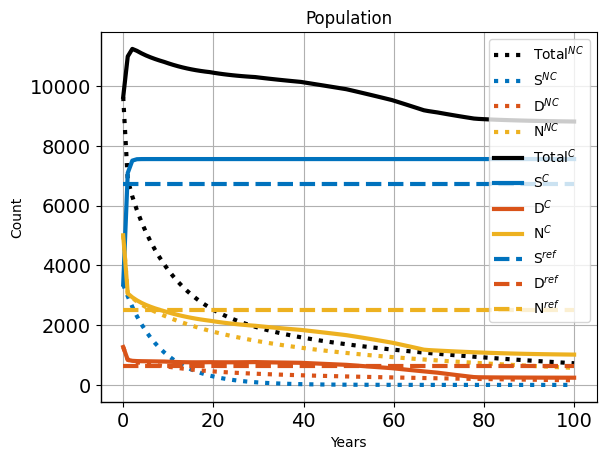

In [6]:
# Plots
colors = [
    [0, 0, 0],
    [0, 0.4470, 0.7410],
    [0.8500, 0.3250, 0.0980],
    [0.9290, 0.6940, 0.1250],
    [0.4940, 0.1840, 0.5560],
    [0.4660, 0.6740, 0.1880],
]
sel_LineWidth = 3
sel_MarkerWidth = 10
sel_LineWidthAxis = 1
sel_FontSize = 14


plt.figure(facecolor='w')
plt.grid(True)
plt.plot(t_prop_nc, N_tot_sum_nc, ':', color=colors[0], linewidth=sel_LineWidth, label="Total$^{NC}$")
plt.plot(t_prop_nc, S_sum_nc, ':', color=colors[1], linewidth=sel_LineWidth, label="S$^{NC}$")
plt.plot(t_prop_nc, D_sum_nc, ':', color=colors[2], linewidth=sel_LineWidth, label="D$^{NC}$")
plt.plot(t_prop_nc, N_sum_nc, ':', color=colors[3], linewidth=sel_LineWidth, label="N$^{NC}$")
plt.plot(t_prop, N_tot_sum, '-', color=colors[0], linewidth=sel_LineWidth, label="Total$^{C}$")
plt.plot(t_prop, S_sum, '-', color=colors[1], linewidth=sel_LineWidth, label="S$^{C}$")
plt.plot(t_prop, D_sum, '-', color=colors[2], linewidth=sel_LineWidth, label="D$^{C}$")
plt.plot(t_prop, N_sum, '-', color=colors[3], linewidth=sel_LineWidth, label="N$^{C}$")
if K_p + K_d != 0:
    if np.sum(ref_S_dot) != 0 and K_p == 0:
        plt.plot(t_prop, np.sum(x0_S) + t_prop * np.sum(ref_S_dot), '--', color=colors[1], linewidth=sel_LineWidth, label="S$^{ref}$")
    else:
        plt.plot(t_prop, np.ones_like(t_prop) * np.sum(ref_S), '--', color=colors[1], linewidth=sel_LineWidth, label="S$^{ref}$")

if np.sum(ref_D_dot) != 0 and K_p_adrD == 0:
    plt.plot(t_prop, np.sum(x0_D) + t_prop * np.sum(ref_D_dot), '--', color=colors[2], linewidth=sel_LineWidth, label="D$^{ref}$")
elif K_p_adrD + K_d_adrD != 0:
    plt.plot(t_prop, np.ones_like(t_prop) * np.sum(ref_D), '--', color=colors[2], linewidth=sel_LineWidth, label="D$^{ref}$")

if np.sum(ref_N_dot) != 0 and K_p_adrN == 0:
    plt.plot(t_prop, np.sum(x0_N) + t_prop * np.sum(ref_N_dot), '--', color=colors[3], linewidth=sel_LineWidth, label="N$^{ref}$")
elif K_p_adrN + K_d_adrN != 0:
    plt.plot(t_prop, np.ones_like(t_prop) * np.sum(ref_N), '--', color=colors[3], linewidth=sel_LineWidth, label="N$^{ref}$")
plt.title("Population")
plt.xlabel("Years")
plt.ylabel("Count")
plt.legend(loc="best")
plt.gca().tick_params(axis='both', which='major', labelsize=sel_FontSize)
plt.gca().spines['bottom'].set_linewidth(sel_LineWidthAxis)
plt.gca().spines['left'].set_linewidth(sel_LineWidthAxis)
# plt.savefig("so_variation_no_fail.pdf", dpi=300)  

